# Support Vector Regressor
Haytham Mohamed

INFS 890 - Spring 2020

In [313]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing, metrics, feature_selection
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.3f}'.format

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [314]:
# 1- read data file
# 1- read processed file
file_dir = '../data/processed-data/'


#data_file = 'factored_dataset.csv'
data_file = 'normalized_dataset.csv'
#data_file = 'standardized_normalized_dataset.csv'

data = pd.read_csv(file_dir + data_file)



In [315]:
data.head(5)

,ltcy,svc_cpu_use,svc_cpu_thr,svc_net_use,svc_disk_use,system_cpu_use,system_cpu_sat,system_net_use,svc_req_size,svc_resp_size,svc_pods,svc_req_rate
0,0.332,0.557,0.332,0.325,0.037,16.982,1.591,3.206,0.002,0.012,7.000,0.980
1,0.400,0.616,0.300,0.351,0.047,20.583,1.608,3.552,0.003,0.019,7.000,1.620
2,0.469,0.608,0.316,0.362,0.039,19.448,1.390,3.586,0.003,0.024,7.000,2.180
3,0.490,0.624,0.300,0.362,0.108,17.319,1.730,3.512,0.003,0.022,6.000,2.130
4,0.500,0.608,0.316,0.374,0.133,16.650,1.917,3.449,0.003,0.023,3.000,2.220


In [316]:
data.shape

(1584, 12)

In [317]:
targets = data['ltcy']
inputs = data.drop(['ltcy'], axis=1)

n_features = inputs.values.shape[1]

#inputs_scaled = scaler.fit_transform(inputs)
#x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=365)

x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=0.1, shuffle=False, random_state=365)

# for better convergence and result scale target to values between 0 - 1
y_train_max = y_train.max()
y_test_max = y_test.max()

y_train = y_train / y_train_max
y_test = y_test / y_test_max

print("there are {} features".format(n_features))


there are 11 features


# Regression with Feature Selection

In [318]:
# -- trying
#selector = feature_selection.SelectKBest(feature_selection.f_regression).fit(x_train, y_train)
#selectedFeatures = selector.transform(x_train)
#print('{} features selected'.format(selectedFeatures[1].shape[0]))

In [319]:
#clf = LassoCV()
#sfm = SelectFromModel(clf) #(clf, threshold=0.01)
#selectedFeatures = sfm.fit(x_train, y_train).transform(x_train)
#print('{} features selected'.format(selectedFeatures[1].shape[0]))

In [320]:
clf = RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=15)
sfm = SelectFromModel(clf,threshold='0.8*mean')

In [321]:
# start:  search grid

# SVR
svr = LinearSVR(random_state=365, verbose=0)   #(C=0.1, random_state=365, verbose=0)

# standardize the features
scaler = StandardScaler()

pipe = Pipeline(steps=[
    ('scaler', scaler),
    ('selector', sfm), 
    ('clf', svr)
])

kfold = KFold(n_splits=10, shuffle=False)

param_grid = {
    'selector__threshold': [.1, .05, .02, .01, .005, 0.001],
    'clf__C': [.01, .05, .1]
}

search = GridSearchCV(pipe, param_grid,scoring='neg_mean_squared_error'
                      , return_train_score= True, cv=kfold, verbose=0, n_jobs=-1)

search.fit(x_train, y_train)


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('selector',
                                        SelectFromModel(estimator=RandomForestRegressor(bootstrap=True,
                                                                                        ccp_alpha=0.0,
                                                                                        criterion='mse',
                                                                                        max_depth=10,
                                                                                        max_features='auto',
                     

In [322]:
estimator = search.best_estimator_
params = search.best_params_
score = search.best_score_

print("Best CV score = %0.3f:" % score)
print("Best CV params = {}".format(params))

print("")
all_training_scores = search.cv_results_
#print("\ncross_validation:\n", all_training_scores , "\n")
print(all_training_scores['mean_train_score'])

print("")
print('Model training Score = {}'.format(search.score(x_train,y_train)))


Best CV score = -0.019:
Best CV params = {'clf__C': 0.1, 'selector__threshold': 0.1}

[-0.01754952 -0.01737768 -0.01707694 -0.01707694 -0.01707694 -0.01707694
 -0.01739619 -0.01712109 -0.01678755 -0.01677845 -0.01677845 -0.01677845
 -0.01739619 -0.01720846 -0.01680941 -0.01676186 -0.01676186 -0.01676186]

Model training Score = -0.017431453200590797


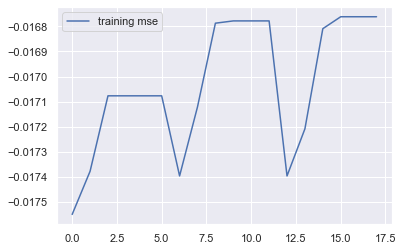

In [323]:
pdf = pd.DataFrame(all_training_scores['mean_train_score'], columns=['training mse'])
pdf.plot()

# Training R2

In [324]:
y_hat = search.predict(x_train)

r2_train = metrics.r2_score(y_train, y_hat)
print('R2 (training) = {}'.format(r2_train))


R2 (training) = 0.2679178165536069


In [325]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_hat)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)


print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.10 (0.08) 0.00 0.56 MSE


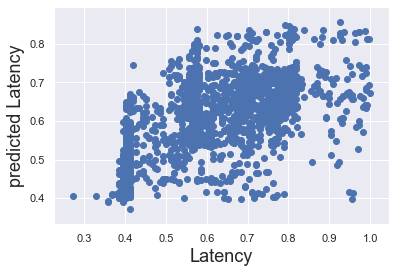

In [326]:
plt.scatter(y_train, y_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
#plt.xlim(-2,3)
#plt.ylim(-3,1)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

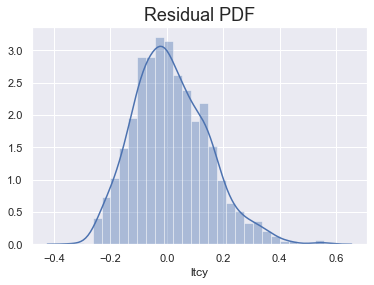

In [327]:
sns.distplot(y_train - y_hat)
plt.title('Residual PDF', size=18)

# Testing

In [328]:
y_hat_test = search.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

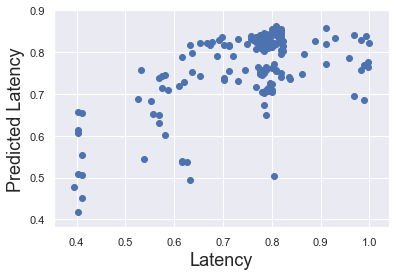

In [329]:
plt.scatter(y_test, y_hat_test)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

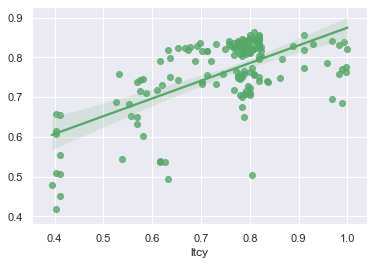

In [330]:
ax = sns.regplot(x=y_test, y=y_hat_test, color='g')

In [331]:
perf = pd.DataFrame(np.exp(y_hat_test), columns=['prediction'])
y_test = y_test.reset_index(drop=True)
perf['target'] = np.exp(y_test)
perf.head()

,prediction,target
0,2.108,1.788
1,2.296,2.256
2,2.092,2.018
3,2.263,2.018
4,2.285,2.219


In [332]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,2.108,1.788,0.320,17.875
1,2.296,2.256,0.040,1.751
2,2.092,2.018,0.074,3.664
3,2.263,2.018,0.245,12.133
4,2.285,2.219,0.066,2.983
...,...,...,...,...
154,2.289,1.999,0.290,14.532
155,2.242,2.181,0.061,2.815
156,2.132,2.181,-0.049,2.243
157,2.300,2.134,0.166,7.775


In [333]:
perf.describe()

,prediction,target,residual,difference%
count,159.000,159.000,159.000,159.000
mean,2.152,2.130,0.022,8.289
std,0.189,0.272,0.221,6.567
min,1.520,1.483,-0.706,0.146
25%,2.077,2.004,-0.107,3.243
50%,2.223,2.200,0.066,6.453
75%,2.290,2.247,0.148,11.567
max,2.373,2.718,0.433,28.930


In [334]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
139,2.08,2.08,0.00,0.15
54,2.29,2.28,0.01,0.45
18,2.28,2.27,0.01,0.48
153,2.15,2.16,-0.01,0.59
102,1.72,1.71,0.01,0.59
55,2.26,2.28,-0.02,0.69
7,2.25,2.23,0.02,1.06
62,2.27,2.25,0.02,1.09
148,2.26,2.24,0.03,1.19
19,2.24,2.27,-0.03,1.33


# Prediction Accuracy

In [335]:
r2_test = metrics.r2_score(y_test, y_hat_test)
print('R2 (testing) = {}'.format(r2_test))

#also: R-Squared could obtain with
#pipe.score(x_test, y_test)

R2 (testing) = 0.38322131704657303


In [336]:
print(np.sqrt(mean_squared_error(y_test,y_hat_test)))

0.10510521737540564
